In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt


In [2]:
np.random.seed(42)

## 1. Blackjack Basic Strategy

In [3]:
# Code is taken from Portfolio 1
class BlackjackEnvironment:
    def __init__(self):
        self.deck = self.generate_deck()
        self.player_hand = []
        self.dealer_hand = []
        self.bankroll = 100
        self.bet = 20
        self.is_playing = False
        self.episode = []
        
    def generate_deck(self):
        suits = ['hearts', 'diamonds', 'clubs', 'spades']
        values = list(range(2, 11)) + ['jack', 'queen', 'king', 'ace']
        deck = []
        for value in values:
            for suit in suits:
                card = str(value) + '_' + suit
                deck.append(card)
        return deck

    def draw_card(self):
        if len(self.deck) == 0:
            self.check_deck()
        card = self.deck.pop(random.randint(0, len(self.deck) - 1))
        return card

    def check_deck(self):
        if len(self.deck) == 0:
            self.deck = self.generate_deck()
            random.shuffle(self.deck)

    def reset(self):
        self.deck = self.generate_deck()
        random.shuffle(self.deck)
        self.player_hand = [self.draw_card(), self.draw_card()]
        self.dealer_hand = [self.draw_card(), self.draw_card()]
        self.bet = 20
        self.episode = []

    def card_value(self, card):
        value = card.split('_')[0]
        if value in ['jack', 'queen', 'king']:
            return 10
        elif value == 'ace':
            return 11
        else:
            return int(value)

    def hand_value(self, hand):
        value = sum(self.card_value(card) for card in hand)
        num_aces = sum(1 for card in hand if card.startswith('ace'))

        while value > 21 and num_aces > 0:
            value -= 10
            num_aces -= 1

        if num_aces > 0 and value > 21:
            value -= 10

        return value

    def is_busted(self, hand):
        return self.hand_value(hand) > 21

    def dealer_play(self):
        while self.hand_value(self.dealer_hand) < 17:
            self.dealer_hand.append(self.draw_card())
    
    def offer_insurance(self):
        player_value = self.hand_value(self.player_hand)
        dealer_upcard = self.card_value(self.dealer_hand[0])
        
        # Player has a natural blackjack and dealer upcard is an Ace
        if player_value == 21 and dealer_upcard == 11:
            # Pay 3:2 for blackjack
            self.bankroll += self.bet * 1.5 
             # No need for insurance in this case
            self.insurance_bet = 0 
        elif dealer_upcard == 11:
            # Dealer upcard is an Ace
            # Take insurance if the deck is rich in 10-value cards
            num_tens = sum(1 for card in self.deck if self.card_value(card) == 10)
            num_remaining_cards = len(self.deck)
            insurance_threshold = num_tens / num_remaining_cards
            # threshold
            if insurance_threshold > 0.3:  
                # Insurance bet is half of the original bet
                insurance_amount = min(self.bankroll, self.bet / 2)  
                self.bankroll -= insurance_amount
                self.insurance_bet = insurance_amount
                if self.hand_value(self.dealer_hand) == 21:
                    # Payout for the insurance bet
                    self.bankroll += self.insurance_bet * 2  
                else:
                    pass
            else:
                self.insurance_bet = 0  

    def double_down(self):
        if self.bet <= self.bankroll:
            self.bet *= 2
            self.player_hand.append(self.draw_card())

            if self.is_busted(self.player_hand):
                self.bankroll -= self.bet
                self.episode.append((self.get_state(), 'double_down', -1))
            else:
                self.dealer_play()
                player_value = self.hand_value(self.player_hand)
                dealer_value = self.hand_value(self.dealer_hand)

                if self.is_busted(self.dealer_hand) or player_value > dealer_value:
                    self.bankroll += self.bet
                    self.episode.append((self.get_state(), 'double_down', 1))
                elif dealer_value > player_value:
                    self.bankroll -= self.bet
                    self.episode.append((self.get_state(), 'double_down', -1))
                else:
                    self.episode.append((self.get_state(), 'double_down', 0))
        else:
            pass

    def place_bet(self):
        self.bet = 20

    def split_pair(self):
        if len(self.player_hand) == 2 and self.card_value(self.player_hand[0]) == self.card_value(self.player_hand[1]):
            card_value = self.card_value(self.player_hand[0])
            print(f"Splitting {card_value}'s...")
            # Create two separate hands from the pair of cards
            hand1 = [self.player_hand[0], self.draw_card()]
            hand2 = [self.player_hand[1], self.draw_card()]
            # Update player_hand to a list of split hands
            self.player_hand = [hand1, hand2]  
        else:
            pass
        
    def hit(self):
        self.player_hand.append(self.draw_card())

    def stand(self):
        self.dealer_play()
        player_value = self.hand_value(self.player_hand)
        dealer_value = self.hand_value(self.dealer_hand)

        if self.is_busted(self.dealer_hand):
            self.bankroll += self.bet
            self.episode.append((self.get_state(), 'stand', 1))
        elif player_value > dealer_value:
            self.bankroll += self.bet
            self.episode.append((self.get_state(), 'stand', 1))
        elif dealer_value > player_value:
            self.bankroll -= self.bet
            self.episode.append((self.get_state(), 'stand', -1))
        else:
            self.episode.append((self.get_state(), 'stand', 0))

    def get_state(self):
        return tuple(self.player_hand), self.dealer_hand[0]

    def play_hand(self, hand):
         # Offer insurance before playing the hand
        self.offer_insurance() 
        while True:
            if isinstance(hand[0], list):
                for subhand in hand:
                    self.play_hand(subhand)
                break

            player_value = self.hand_value(hand)
            dealer_upcard = self.card_value(self.dealer_hand[0])

            if player_value <= 8:
                hand.append(self.draw_card())
                if self.is_busted(hand):
                    # Deduct the minimum between the bet and bankroll
                    self.bankroll -= min(self.bankroll, self.bet)  
                    self.episode.append((self.get_state(), 'hit', -1))
                    break

            elif player_value >= 17:
                self.dealer_play()
                if self.is_busted(self.dealer_hand):
                    self.bankroll += self.bet
                    self.episode.append((self.get_state(), 'stand', 1))
                else:
                    player_value = self.hand_value(hand)
                    dealer_value = self.hand_value(self.dealer_hand)
                    if player_value > dealer_value:
                        self.bankroll += self.bet
                        self.episode.append((self.get_state(), 'stand', 1))
                    elif dealer_value > player_value:
                        # Deduct the minimum between the bet and bankroll
                        self.bankroll -= min(self.bankroll, self.bet)  
                        self.episode.append((self.get_state(), 'stand', -1))
                    else:
                        self.episode.append((self.get_state(), 'stand', 0))
                break

            elif 2 <= dealer_upcard <= 6:
                self.dealer_play()
                if self.is_busted(self.dealer_hand):
                    self.bankroll += self.bet
                    self.episode.append((self.get_state(), 'stand', 1))
                else:
                    player_value = self.hand_value(hand)
                    dealer_value = self.hand_value(self.dealer_hand)
                    if player_value > dealer_value:
                        self.bankroll += self.bet
                        self.episode.append((self.get_state(), 'stand', 1))
                    elif dealer_value > player_value:
                         # Deduct the minimum between the bet and bankroll
                        self.bankroll -= min(self.bankroll, self.bet) 
                        self.episode.append((self.get_state(), 'stand', -1))
                    else:
                        self.episode.append((self.get_state(), 'stand', 0))
                break

            elif player_value == 9 or player_value == 10 or player_value == 11:
                self.double_down()
                self.episode.append((self.get_state(), 'double_down', 1))
                break

            elif player_value == self.card_value(hand[0]):
                self.split_pair()
                self.episode.append((self.get_state(), 'split', 0))

                for subhand in self.player_hand:
                    self.episode.append((self.get_state(), 'split', 0))
                    self.play_hand(subhand)
                break

            else:
                hand.append(self.draw_card())
                if self.is_busted(hand):
                    # Deduct the minimum between the bet and bankroll
                    self.bankroll -= min(self.bankroll, self.bet)  
                    self.episode.append((self.get_state(), 'hit', -1))
                    break

    def get_episode(self):
        # Wrap the episode list in another list
        return [self.episode]  

    def play(self, num_episodes, epsilon):
        print("Welcome to Blackjack!")
        print(f"Your current bankroll: {self.bankroll}")
        self.is_playing = True
        # Variable to track the current episode number
        current_episode = 0  
        # Collect all episodes
        all_episodes = []  

        for _ in range(num_episodes):
            self.reset()
            self.place_bet()
            self.play_hand(self.player_hand)
            # Get the episode for the current game
            episode = self.get_episode()  
            # Add the episode to the list of all episodes
            all_episodes.extend(episode)  
            if _ < num_episodes - 1:
                # Reset the episode list for the next episode
                self.episode = []  
                
        print("\nThank you for playing Blackjack!")
        print(f"Final Bankroll: {self.bankroll}")

        current_episode = _ + 1
        agent.update_policy(all_episodes, alpha, gamma)
        # Update the policy using all episodes
        return all_episodes

    def calculate_performance_metrics(self, num_episodes):
        total_bankroll = 0
        total_winnings = 0
        total_wins = 0

        for _ in range(num_episodes):
            self.reset()
            self.place_bet()
            self.play_hand(self.player_hand)

            total_bankroll += self.bankroll
             # Calculate the winnings relative to the initial bankroll
            total_winnings += self.bankroll - 100 
            if self.bankroll > 100:
                total_wins += 1

        average_bankroll = total_bankroll / num_episodes
        win_rate = total_wins / num_episodes
        average_winnings = total_winnings / num_episodes

        return average_bankroll, win_rate, average_winnings
    
    
   



In [4]:
# Define a function to calculate cumulative rewards from the episodes
def calculate_cumulative_rewards(episodes):
    cumulative_rewards = []
    cumulative_reward = 0
    for episode in episodes:
        _, _, rewards = zip(*episode)
        cumulative_reward += sum(rewards)
        cumulative_rewards.append(cumulative_reward)
    return cumulative_rewards

In [5]:
def plot_cumulative_rewards(episodes_agent1 , episodes_agent2):
    # Calculate cumulative reward
    cumulative_rewards_on = calculate_cumulative_rewards(episodes_agent1)
    cumulative_rewards_off = calculate_cumulative_rewards(episodes_agent2)

    # Plot the cumulative rewards for both agents in one graph
    plt.plot(range(1, num_episodes + 1), cumulative_rewards_on, label='On-Policy')
    plt.plot(range(1, num_episodes + 1), cumulative_rewards_off, label='Off-Policy')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title('Cumulative Reward vs. Episode')
    plt.legend()
    plt.grid(True)
    plt.show()

## 1.1. On-Policy 

In [6]:
class OnPolicyBlackjackAgent:
    def __init__(self):
        self.Q = {}
        self.N = {}

    def get_action(self, state, epsilon):
        action_values = self.Q.get(state, {})
        if action_values:
            values = np.array(list(action_values.values()))
            probabilities = np.exp(values / epsilon) / np.sum(np.exp(values / epsilon))
            actions = list(action_values.keys())
            return np.random.choice(actions, p=probabilities)
        else:
            return random.choice(['hit', 'stand', 'double_down', 'split'])

    def update_policy(self, episodes, alpha, gamma):
        for episode in episodes:
            if not episode:
                # Skip empty episodes
                continue  

            states, actions, rewards = zip(*episode)
            G = 0
            for t in reversed(range(len(states))):
                state = states[t]
                action = actions[t]
                reward = rewards[t]
                G = gamma * G + reward
                self.N[state] = self.N.get(state, {})
                self.N[state][action] = self.N[state].get(action, 0) + 1
                alpha_t = alpha / self.N[state][action]
                self.Q[state] = self.Q.get(state, {})
                self.Q[state][action] = self.Q[state].get(action, 0) + alpha_t * (G - self.Q[state].get(action, 0))

In [7]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 1  # exploration rate
alpha = 0.5 # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
on_policy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 0.0
Average Bankroll: 101.50285
Win Rate: 0.366785
Average Winnings: 1.50285


### 1.1.1 Different Learning rates

In [8]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.1 # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
on_policy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 20.0
Average Bankroll: 112.7072
Win Rate: 0.37675
Average Winnings: 12.7072


In [9]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.3 # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
on_policy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 60.0
Average Bankroll: 103.02475
Win Rate: 0.353895
Average Winnings: 3.02475


In [10]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.5 # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
on_policy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 50.0
Average Bankroll: 111.01845
Win Rate: 0.370165
Average Winnings: 11.01845


In [11]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.7 # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
on_policy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 40.0
Average Bankroll: 106.06625
Win Rate: 0.35902
Average Winnings: 6.06625


In [12]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.9 # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
on_policy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 470.0
Average Bankroll: 101.05355
Win Rate: 0.3438
Average Winnings: 1.05355


### 1.1.2. Different Epsilon Values

In [13]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.5 # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
on_policy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 140.0
Average Bankroll: 96.6583
Win Rate: 0.343615
Average Winnings: -3.3417


In [14]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.3  # exploration rate
alpha = 0.5 # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
on_policy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 20.0
Average Bankroll: 106.3245
Win Rate: 0.36168
Average Winnings: 6.3245


In [15]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.5  # exploration rate
alpha = 0.5 # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
on_policy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 40.0
Average Bankroll: 98.3307
Win Rate: 0.346305
Average Winnings: -1.6693


In [16]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.7  # exploration rate
alpha = 0.5 # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
on_policy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 0.0
Average Bankroll: 103.1894
Win Rate: 0.350955
Average Winnings: 3.1894


In [17]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.9  # exploration rate
alpha = 0.5 # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
on_policy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 0.0
Average Bankroll: 108.1453
Win Rate: 0.368635
Average Winnings: 8.1453


### 1.1.3. Different Discount Factor

In [18]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.5 # learning rate 
gamma = 0.7  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
on_policy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 90.0
Average Bankroll: 105.0832
Win Rate: 0.362585
Average Winnings: 5.0832


In [19]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.5 # learning rate 
gamma = 0.8  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
on_policy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 180.0
Average Bankroll: 105.82305
Win Rate: 0.370285
Average Winnings: 5.82305


In [20]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.5 # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
on_policy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 0.0
Average Bankroll: 102.69825
Win Rate: 0.359705
Average Winnings: 2.69825


In [21]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.5 # learning rate 
gamma = 0.95  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
on_policy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 0.0
Average Bankroll: 103.6169
Win Rate: 0.36545
Average Winnings: 3.6169


In [22]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.5 # learning rate 
gamma = 0.99  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
on_policy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 120.0
Average Bankroll: 103.36735
Win Rate: 0.354425
Average Winnings: 3.36735


## 1.2. Off-Policy

In [23]:
class OffPolicyBlackjackAgent:
    def __init__(self):
        self.Q = {}
        self.C = {}

    def get_action(self, state, epsilon):
        action_values = self.Q.get(state, {})
        if action_values:
            values = np.array(list(action_values.values()))
            probabilities = np.exp(values / epsilon) / np.sum(np.exp(values / epsilon))
            actions = list(action_values.keys())
            # Return actions and their probabilities
            return actions, probabilities  
        else:
             # Initialize Q-values for unseen state
            self.Q[state] = {'hit': 0, 'stand': 0, 'double_down': 0, 'split': 0} 
            # Return equal probabilities for all actions
            return ['hit', 'stand', 'double_down', 'split'], [0.25, 0.25, 0.25, 0.25]  

    def update_policy(self, episodes, alpha, gamma):
        for episode in episodes:
            if not episode:
                # Skip empty episodes
                continue  

            states, actions, rewards = zip(*episode)
            G = 0
            W = 1  # Importance sampling ratio
            for t in reversed(range(len(states))):
                state = states[t]
                action = actions[t]
                reward = rewards[t]
                G = gamma * G + reward

                self.C[state] = self.C.get(state, {})
                self.C[state][action] = self.C[state].get(action, 0) + W
                rho = self.get_importance_sampling_ratio(states, actions, t)
                alpha_t = alpha / self.C[state][action]
                self.Q[state] = self.Q.get(state, {})
                self.Q[state][action] = self.Q[state].get(action, 0) + alpha_t * (rho * (G - self.Q[state].get(action, 0)))

    def get_importance_sampling_ratio(self, states, actions, t):
        rho = 1.0
        for i in range(t):
            state = states[i]
            action = actions[i]
            _, behavior_probabilities = self.get_action(state, epsilon)
            target_prob = np.exp(self.Q[state][action] / epsilon) / np.sum(np.exp(np.array(list(self.Q[state].values())) / epsilon))
            behavior_prob = behavior_probabilities[i]
            rho *= target_prob / behavior_prob
        return rho
   


In [24]:
agent = OffPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.5  # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
off_policy_episodes = environment.play(num_episodes, epsilon)

average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 290.0
Average Bankroll: 109.624
Win Rate: 0.364785
Average Winnings: 9.624


### 1.2.1. Different Learning Rates

In [25]:
agent = OffPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.1  # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
off_policy_episodes = environment.play(num_episodes, epsilon)

average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 240.0
Average Bankroll: 101.44825
Win Rate: 0.355795
Average Winnings: 1.44825


In [26]:
agent = OffPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.3  # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
off_policy_episodes = environment.play(num_episodes, epsilon)

average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 40.0
Average Bankroll: 105.44035
Win Rate: 0.357365
Average Winnings: 5.44035


In [27]:
agent = OffPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.5  # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
off_policy_episodes = environment.play(num_episodes, epsilon)

average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 130.0


C:\Users\Mian\AppData\Local\Temp\ipykernel_23160\1128298321.py:10: RuntimeWarning: overflow encountered in exp
  probabilities = np.exp(values / epsilon) / np.sum(np.exp(values / epsilon))
C:\Users\Mian\AppData\Local\Temp\ipykernel_23160\1128298321.py:10: RuntimeWarning: invalid value encountered in divide
  probabilities = np.exp(values / epsilon) / np.sum(np.exp(values / epsilon))
C:\Users\Mian\AppData\Local\Temp\ipykernel_23160\1128298321.py:48: RuntimeWarning: overflow encountered in exp
  target_prob = np.exp(self.Q[state][action] / epsilon) / np.sum(np.exp(np.array(list(self.Q[state].values())) / epsilon))
C:\Users\Mian\AppData\Local\Temp\ipykernel_23160\1128298321.py:48: RuntimeWarning: invalid value encountered in scalar divide
  target_prob = np.exp(self.Q[state][action] / epsilon) / np.sum(np.exp(np.array(list(self.Q[state].values())) / epsilon))


Average Bankroll: 99.44855
Win Rate: 0.34168
Average Winnings: -0.55145


In [28]:
agent = OffPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.7  # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
off_policy_episodes = environment.play(num_episodes, epsilon)

average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 100.0
Average Bankroll: 100.1338
Win Rate: 0.35152
Average Winnings: 0.1338


In [29]:
agent = OffPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.9  # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
off_policy_episodes = environment.play(num_episodes, epsilon)

average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 140.0
Average Bankroll: 103.1034
Win Rate: 0.35894
Average Winnings: 3.1034


### 1.2.2. Different Epsilon Values

In [30]:
agent = OffPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.5  # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
off_policy_episodes = environment.play(num_episodes, epsilon)

average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 80.0
Average Bankroll: 104.05445
Win Rate: 0.36229
Average Winnings: 4.05445


In [31]:
agent = OffPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.3  # exploration rate
alpha = 0.5  # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
off_policy_episodes = environment.play(num_episodes, epsilon)

average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 0.0
Average Bankroll: 105.7208
Win Rate: 0.361155
Average Winnings: 5.7208


In [32]:
agent = OffPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.5  # exploration rate
alpha = 0.5  # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
off_policy_episodes = environment.play(num_episodes, epsilon)

average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 340.0
Average Bankroll: 104.0627
Win Rate: 0.36237
Average Winnings: 4.0627


In [33]:
agent = OffPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.7  # exploration rate
alpha = 0.5  # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
off_policy_episodes = environment.play(num_episodes, epsilon)

average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 20.0
Average Bankroll: 105.10175
Win Rate: 0.363495
Average Winnings: 5.10175


In [34]:
agent = OffPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.9  # exploration rate
alpha = 0.5  # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
off_policy_episodes = environment.play(num_episodes, epsilon)

average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 160.0
Average Bankroll: 99.63965
Win Rate: 0.34548
Average Winnings: -0.36035


### 1.2.3. Different Discount Factor 

In [35]:
agent = OffPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.5  # learning rate 
gamma = 0.7  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
off_policy_episodes = environment.play(num_episodes, epsilon)

average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 0.0
Average Bankroll: 102.2214
Win Rate: 0.3522
Average Winnings: 2.2214


In [36]:
agent = OffPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.5  # learning rate 
gamma = 0.8  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
off_policy_episodes = environment.play(num_episodes, epsilon)

average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 0.0
Average Bankroll: 102.66965
Win Rate: 0.35958
Average Winnings: 2.66965


In [37]:
agent = OffPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.5  # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
off_policy_episodes = environment.play(num_episodes, epsilon)

average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 20.0
Average Bankroll: 103.95365
Win Rate: 0.3546
Average Winnings: 3.95365


In [38]:
agent = OffPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.5  # learning rate 
gamma = 0.95  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
off_policy_episodes = environment.play(num_episodes, epsilon)

average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 210.0
Average Bankroll: 104.9645
Win Rate: 0.358
Average Winnings: 4.9645


In [39]:
agent = OffPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.5  # learning rate 
gamma = 0.99  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
off_policy_episodes = environment.play(num_episodes, epsilon)

average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 20.0


C:\Users\Mian\AppData\Local\Temp\ipykernel_23160\1128298321.py:10: RuntimeWarning: overflow encountered in exp
  probabilities = np.exp(values / epsilon) / np.sum(np.exp(values / epsilon))
C:\Users\Mian\AppData\Local\Temp\ipykernel_23160\1128298321.py:10: RuntimeWarning: invalid value encountered in divide
  probabilities = np.exp(values / epsilon) / np.sum(np.exp(values / epsilon))
C:\Users\Mian\AppData\Local\Temp\ipykernel_23160\1128298321.py:48: RuntimeWarning: overflow encountered in exp
  target_prob = np.exp(self.Q[state][action] / epsilon) / np.sum(np.exp(np.array(list(self.Q[state].values())) / epsilon))
C:\Users\Mian\AppData\Local\Temp\ipykernel_23160\1128298321.py:48: RuntimeWarning: invalid value encountered in scalar divide
  target_prob = np.exp(self.Q[state][action] / epsilon) / np.sum(np.exp(np.array(list(self.Q[state].values())) / epsilon))


Average Bankroll: 113.46235
Win Rate: 0.38406
Average Winnings: 13.46235


# Plot Basic Strategy 

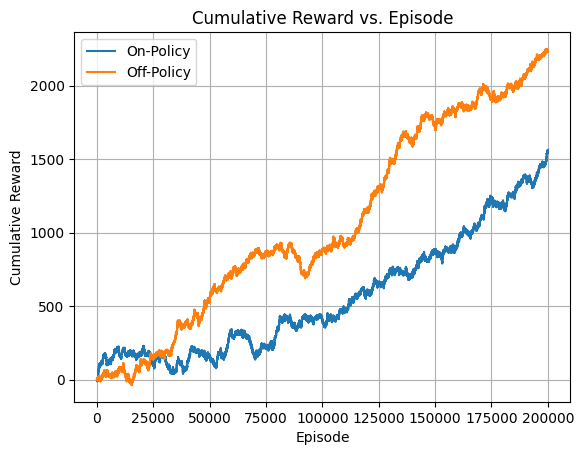

In [40]:
plot_cumulative_rewards(on_policy_episodes, off_policy_episodes)

# 2. Complete Counting System 

In [41]:
class BlackjackEnvironment:
    def __init__(self):
        self.deck = self.generate_deck()
        self.player_hand = []
        self.dealer_hand = []
        self.bankroll = 100
        self.bet = 20
        self.is_playing = False
        self.episode = []
        self.running_count = 0
        self.true_count = 0

    def generate_deck(self):
        suits = ['hearts', 'diamonds', 'clubs', 'spades']
        values = list(range(2, 11)) + ['jack', 'queen', 'king', 'ace']
        deck = []
        for value in values:
            for suit in suits:
                card = str(value) + '_' + suit
                deck.append(card)
        return deck

    def draw_card(self):
        if len(self.deck) == 0:
            self.check_deck()
        card = self.deck.pop(random.randint(0, len(self.deck) - 1))
        return card

    def check_deck(self):
        if len(self.deck) == 0:
            print("The deck is running out of cards. Creating a new deck...")
            self.deck = self.generate_deck()
            random.shuffle(self.deck)

    def reset(self):
        self.deck = self.generate_deck()
        random.shuffle(self.deck)
        self.player_hand = [self.draw_card(), self.draw_card()]
        self.dealer_hand = [self.draw_card(), self.draw_card()]
        self.bet = 20
        self.episode = []

    def card_value(self, card):
        value = card.split('_')[0]
        if value in ['jack', 'queen', 'king']:
            return 10
        elif value == 'ace':
            return 11
        else:
            return int(value)

    def hand_value(self, hand):
        value = sum(self.card_value(card) for card in hand)
        num_aces = sum(1 for card in hand if card.startswith('ace'))

        while value > 21 and num_aces > 0:
            value -= 10
            num_aces -= 1

        if num_aces > 0 and value > 21:
            value -= 10

        return value

    def is_busted(self, hand):
        return self.hand_value(hand) > 21

    def dealer_play(self):
        while self.hand_value(self.dealer_hand) < 17:
            self.dealer_hand.append(self.draw_card())
    def offer_insurance(self):
        player_value = self.hand_value(self.player_hand)
        dealer_upcard = self.card_value(self.dealer_hand[0])

        if player_value == 21 and dealer_upcard == 11:
            # Player has a natural blackjack and dealer upcard is an Ace
            # Pay 3:2 for blackjack
            self.bankroll += self.bet * 1.5  
            # No need for insurance in this case
            self.insurance_bet = 0  
        elif dealer_upcard == 11:
            # Dealer upcard is an Ace
            # Take insurance if the deck is rich in 10-value cards
            num_tens = sum(1 for card in self.deck if self.card_value(card) == 10)
            num_remaining_cards = len(self.deck)
            insurance_threshold = num_tens / num_remaining_cards
            if insurance_threshold > 0.3:  
                # Insurance bet is half of the original bet
                insurance_amount = min(self.bankroll, self.bet / 2)  
                self.bankroll -= insurance_amount
                self.insurance_bet = insurance_amount
                if self.hand_value(self.dealer_hand) == 21:
                    # Payout for the insurance bet
                    self.bankroll += self.insurance_bet * 2  
                else:
                    pass
            else:
                self.insurance_bet = 0  

    def double_down(self):
        if self.bet <= self.bankroll:
            self.bet *= 2
            self.player_hand.append(self.draw_card())

            if self.is_busted(self.player_hand):
                self.bankroll -= self.bet
                self.episode.append((self.get_state(), 'double_down', -1))
            else:
                self.dealer_play()
                player_value = self.hand_value(self.player_hand)
                dealer_value = self.hand_value(self.dealer_hand)

                if self.is_busted(self.dealer_hand) or player_value > dealer_value:
                    self.bankroll += self.bet
                    self.episode.append((self.get_state(), 'double_down', 1))
                elif dealer_value > player_value:
                    self.bankroll -= self.bet
                    self.episode.append((self.get_state(), 'double_down', -1))
                else:
                    self.episode.append((self.get_state(), 'double_down', 0))
        else:
            pass

    def place_bet(self):
        self.bet = 20

    def split_pair(self):
        if len(self.player_hand) == 2 and self.card_value(self.player_hand[0]) == self.card_value(self.player_hand[1]):
            card_value = self.card_value(self.player_hand[0])
            print(f"Splitting {card_value}'s...")
            # Create two separate hands from the pair of cards
            hand1 = [self.player_hand[0], self.draw_card()]
            hand2 = [self.player_hand[1], self.draw_card()]
            # Update player_hand to a list of split hands
            self.player_hand = [hand1, hand2]  
        else:
            print("Split not possible. You must have a pair of cards with the same value.")

    def hit(self):
        self.player_hand.append(self.draw_card())

    def stand(self):
        self.dealer_play()
        player_value = self.hand_value(self.player_hand)
        dealer_value = self.hand_value(self.dealer_hand)

        if self.is_busted(self.dealer_hand):
            self.bankroll += self.bet
            self.episode.append((self.get_state(), 'stand', 1))
        elif player_value > dealer_value:
            self.bankroll += self.bet
            self.episode.append((self.get_state(), 'stand', 1))
        elif dealer_value > player_value:
            self.bankroll -= self.bet
            self.episode.append((self.get_state(), 'stand', -1))
        else:
            self.episode.append((self.get_state(), 'stand', 0))

    def get_state(self):
        return tuple(self.player_hand), self.dealer_hand[0]
    
    def update_running_count(self, card):
        value = self.card_value(card)
        if value in [2, 3, 4, 5, 6]:
            self.running_count += 1
        elif value in [10, 'jack', 'queen', 'king', 'ace']:
            self.running_count -= 1

    def calculate_true_count(self):
        num_remaining_cards = len(self.deck)
        num_decks_remaining = num_remaining_cards / 52
        self.true_count = self.running_count / num_decks_remaining

    def adjust_strategy_based_on_true_count(self):
        self.calculate_true_count()

        if self.true_count >= 1:
            # Increase the bet as the true count increases
            self.bet *= int(self.true_count)
            # Adjust playing strategy based on the true count
            player_value = self.hand_value(self.player_hand)
            dealer_upcard = self.card_value(self.dealer_hand[0])

            if self.true_count >= 1 and player_value == 16 and dealer_upcard in [9, 10, 11]:
                # True count is 1 or higher, player has a hand value of 16, and dealer's upcard is 9, 10, or Ace
                self.bankroll -= self.bet / 2
                return "surrender"
            elif self.true_count >= 2 and player_value == 10 and dealer_upcard != 10:
                # True count is 2 or higher, player has a hand value of 10, and dealer's upcard is not 10
                self.double_down()
                return "double_down"
            elif self.true_count >= 3 and player_value == 12 and dealer_upcard in [2, 3, 4, 5, 6]:
                # True count is 3 or higher, player has a hand value of 12, and dealer's upcard is 2, 3, 4, 5, or 6
                self.stand()
                return "stand"
            elif self.true_count >= 4 and player_value >= 13 and dealer_upcard in [2, 3, 4, 5, 6]:
                # True count is 4 or higher, player has a hand value of 13 or higher, and dealer's upcard is 2, 3, 4, 5, or 6
                self.stand()
                return "stand"
            elif self.true_count >= 1 and player_value >= 13 and dealer_upcard in [7, 8, 9, 10, 11]:
                # True count is 1 or higher, player has a hand value of 13 or higher, and dealer's upcard is 7, 8, 9, 10, or Ace
                self.hit()
                return "hit"
            elif self.true_count >= 3 and player_value >= 15 and dealer_upcard == 10:
                # True count is 3 or higher, player has a hand value of 15 or higher, and dealer's upcard is 10
                self.hit()
                return "hit"
            elif self.true_count >= 2 and player_value >= 17:
                # True count is 2 or higher and player has a hand value of 17 or higher
                self.stand()
                return "stand"
            else:
                pass
        else:
            pass

    def play_hand(self, hand):   
        # Offer insurance before playing the hand
        self.offer_insurance()  
        while True:
            if isinstance(hand[0], list):
                for subhand in hand:
                    self.play_hand(subhand)
                break

            player_value = self.hand_value(hand)
            dealer_upcard = self.card_value(self.dealer_hand[0])
            action = self.adjust_strategy_based_on_true_count()

            if action == "surrender":
                self.bankroll -= self.bet / 2
                self.episode.append((self.get_state(), 'surrender', -1))
                break
            elif action == "double_down":
                self.double_down()
                self.episode.append((self.get_state(), 'double_down', 1))
                break
            elif action == "split":
                self.split_pair()
                self.episode.append((self.get_state(), 'split', 0))
                continue
            elif action == "hit":
                self.hit()
                if self.is_busted(hand):
                    self.bankroll -= min(self.bankroll, self.bet)
                    self.episode.append((self.get_state(), 'hit', -1))
                    break
            elif action == "stand":
                self.stand()
                self.episode.append((self.get_state(), 'stand', 0))
                break
            else:
                if player_value <= 8:
                    hand.append(self.draw_card())
                    if self.is_busted(hand):
                        self.bankroll -= min(self.bankroll, self.bet)
                        self.episode.append((self.get_state(), 'hit', -1))
                        break
                elif player_value >= 17:
                    self.dealer_play()
                    if self.is_busted(self.dealer_hand):
                        self.bankroll += self.bet
                        self.episode.append((self.get_state(), 'stand', 1))
                    else:
                        player_value = self.hand_value(hand)
                        dealer_value = self.hand_value(self.dealer_hand)
                        if player_value > dealer_value:
                            self.bankroll += self.bet
                            self.episode.append((self.get_state(), 'stand', 1))
                        elif dealer_value > player_value:
                            self.bankroll -= min(self.bankroll, self.bet)
                            self.episode.append((self.get_state(), 'stand', -1))
                        else:
                            self.episode.append((self.get_state(), 'stand', 0))
                    break
                elif 2 <= dealer_upcard <= 6:
                    self.dealer_play()
                    if self.is_busted(self.dealer_hand):
                        self.bankroll += self.bet
                        self.episode.append((self.get_state(), 'stand', 1))
                    else:
                        player_value = self.hand_value(hand)
                        dealer_value = self.hand_value(self.dealer_hand)
                        if player_value > dealer_value:
                            self.bankroll += self.bet
                            self.episode.append((self.get_state(), 'stand', 1))
                        elif dealer_value > player_value:
                            self.bankroll -= min(self.bankroll, self.bet)
                            self.episode.append((self.get_state(), 'stand', -1))
                        else:
                            self.episode.append((self.get_state(), 'stand', 0))
                    break
                elif player_value == 9 or player_value == 10 or player_value == 11:
                    self.double_down()
                    self.episode.append((self.get_state(), 'double_down', 1))
                    break
                elif player_value == self.card_value(hand[0]):
                    self.split_pair()
                    self.episode.append((self.get_state(), 'split', 0))
                    for subhand in self.player_hand:
                        self.episode.append((self.get_state(), 'split', 0))
                        self.play_hand(subhand)
                    break
                else:
                    hand.append(self.draw_card())
                    if self.is_busted(hand):
                        self.bankroll -= min(self.bankroll, self.bet)
                        self.episode.append((self.get_state(), 'hit', -1))
                        break

    def get_episode(self):
        # Wrap the episode list in another list
        return [self.episode]  

    def play(self, num_episodes, epsilon):
        print("Welcome to Blackjack!")
        print(f"Your current bankroll: {self.bankroll}")
        self.is_playing = True
        # Variable to track the current episode number
        current_episode = 0  
        # Collect all episodes
        all_episodes = [] 

        for _ in range(num_episodes):
            self.reset()
            self.place_bet()
            self.play_hand(self.player_hand)
            # Get the episode for the current game
            episode = self.get_episode()
            # Add the episode to the list of all episodes
            all_episodes.extend(episode)  

            if _ < num_episodes - 1:
                # Reset the episode list for the next episode
                self.episode = []  

        print("\nThank you for playing Blackjack!")
        print(f"Final Bankroll: {self.bankroll}")

        current_episode = _ + 1
        agent.update_policy(all_episodes, alpha, gamma)
        # Update the policy using all episodes
        return all_episodes

    
    def calculate_performance_metrics(self, num_episodes):
        total_bankroll = 0
        total_winnings = 0
        total_wins = 0

        for _ in range(num_episodes):
            self.reset()
            self.place_bet()
            self.play_hand(self.player_hand)

            total_bankroll += self.bankroll
            # Calculate the winnings relative to the initial bankroll
            total_winnings += self.bankroll - 100  

            if self.bankroll > 100:
                total_wins += 1

        average_bankroll = total_bankroll / num_episodes
        win_rate = total_wins / num_episodes
        average_winnings = total_winnings / num_episodes

        return average_bankroll, win_rate, average_winnings




## 2.2. On-Policy

In [42]:
class OnPolicyBlackjackAgent:
    def __init__(self):
        self.Q = {}
        self.N = {}

    def get_action(self, state, epsilon):
        action_values = self.Q.get(state, {})
        if action_values:
            values = np.array(list(action_values.values()))
            probabilities = np.exp(values / epsilon) / np.sum(np.exp(values / epsilon))
            actions = list(action_values.keys())
            return np.random.choice(actions, p=probabilities)
        else:
            return random.choice(['hit', 'stand', 'double_down', 'split'])

    def update_policy(self, episodes, alpha, gamma):
        for episode in episodes:
            if not episode:
                continue  

            states, actions, rewards = zip(*episode)
            G = 0
            for t in reversed(range(len(states))):
                state = states[t]
                action = actions[t]
                reward = rewards[t]
                G = gamma * G + reward
                self.N[state] = self.N.get(state, {})
                self.N[state][action] = self.N[state].get(action, 0) + 1
                alpha_t = alpha / self.N[state][action]
                self.Q[state] = self.Q.get(state, {})
                self.Q[state][action] = self.Q[state].get(action, 0) + alpha_t * (G - self.Q[state].get(action, 0))

In [43]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 100000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.5  # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
on_plolicy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 0.0
Average Bankroll: 96.1053
Win Rate: 0.34069
Average Winnings: -3.8947


### 2.2.1 Different Learning Rates

In [44]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 100000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.1  # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
on_plolicy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 20.0
Average Bankroll: 112.6134
Win Rate: 0.36728
Average Winnings: 12.6134


In [45]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 100000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.3  # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
on_plolicy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 0.0
Average Bankroll: 98.0188
Win Rate: 0.34145
Average Winnings: -1.9812


In [46]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 100000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.5  # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
on_plolicy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 30.0
Average Bankroll: 105.0873
Win Rate: 0.35786
Average Winnings: 5.0873


In [47]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 100000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.7  # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
on_plolicy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 190.0
Average Bankroll: 102.6841
Win Rate: 0.354
Average Winnings: 2.6841


In [48]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 100000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.9  # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
on_plolicy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 280.0
Average Bankroll: 115.0641
Win Rate: 0.37925
Average Winnings: 15.0641


### 2.2.2 Different Epsilon Values

In [49]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 100000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.5 # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
on_plolicy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 20.0
Average Bankroll: 112.337
Win Rate: 0.38578
Average Winnings: 12.337


In [50]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 100000  # number of episodes
epsilon = 0.3  # exploration rate
alpha = 0.1  # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
on_plolicy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 170.0
Average Bankroll: 101.9384
Win Rate: 0.35313
Average Winnings: 1.9384


In [51]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 100000  # number of episodes
epsilon = 0.5  # exploration rate
alpha = 0.1  # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
on_plolicy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 550.0
Average Bankroll: 109.6275
Win Rate: 0.3828
Average Winnings: 9.6275


In [52]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 100000  # number of episodes
epsilon = 0.7  # exploration rate
alpha = 0.1  # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
on_plolicy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 40.0
Average Bankroll: 119.422
Win Rate: 0.38842
Average Winnings: 19.422


In [53]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 100000  # number of episodes
epsilon = 0.9  # exploration rate
alpha = 0.1  # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
on_plolicy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 100.0
Average Bankroll: 101.0863
Win Rate: 0.34292
Average Winnings: 1.0863


### 2.2.3 Different Discount Factor 

In [54]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 100000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.5  # learning rate 
gamma = 0.7  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
on_plolicy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 460.0
Average Bankroll: 100.8405
Win Rate: 0.35019
Average Winnings: 0.8405


In [55]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 100000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.5  # learning rate 
gamma = 0.8  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
on_plolicy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 0.0
Average Bankroll: 107.7281
Win Rate: 0.37859
Average Winnings: 7.7281


In [56]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 100000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.5  # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
on_plolicy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 60.0
Average Bankroll: 98.2272
Win Rate: 0.35466
Average Winnings: -1.7728


In [57]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 100000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.5  # learning rate 
gamma = 0.95  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
on_plolicy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 100.0
Average Bankroll: 106.9799
Win Rate: 0.36469
Average Winnings: 6.9799


In [58]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 100000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.5  # learning rate 
gamma = 0.99  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
on_plolicy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 0.0
Average Bankroll: 108.3204
Win Rate: 0.37794
Average Winnings: 8.3204


## 2.3. Off-Policy

In [59]:
class OffPolicyBlackjackAgent:
    def __init__(self):
        self.Q = {}
        self.C = {}

    def get_action(self, state, epsilon):
        action_values = self.Q.get(state, {})
        if action_values:
            values = np.array(list(action_values.values()))
            probabilities = np.exp(values / epsilon) / np.sum(np.exp(values / epsilon))
            actions = list(action_values.keys())
            # Return actions and their probabilities
            return actions, probabilities  
        else:
            # Initialize Q-values for unseen state
            self.Q[state] = {'hit': 0, 'stand': 0, 'double_down': 0, 'split': 0}  
            # Return equal probabilities for all actions
            return ['hit', 'stand', 'double_down', 'split'], [0.25, 0.25, 0.25, 0.25]  

    def update_policy(self, episodes, alpha, gamma):
        for episode in episodes:
            if not episode:
                continue  

            states, actions, rewards = zip(*episode)
            G = 0
            W = 1  # Importance sampling ratio
            for t in reversed(range(len(states))):
                state = states[t]
                action = actions[t]
                reward = rewards[t]
                G = gamma * G + reward

                self.C[state] = self.C.get(state, {})
                self.C[state][action] = self.C[state].get(action, 0) + W
                rho = self.get_importance_sampling_ratio(states, actions, t)
                alpha_t = alpha / self.C[state][action]
                self.Q[state] = self.Q.get(state, {})
                self.Q[state][action] = self.Q[state].get(action, 0) + alpha_t * (rho * (G - self.Q[state].get(action, 0)))

    def get_importance_sampling_ratio(self, states, actions, t):
        rho = 1.0
        for i in range(t):
            state = states[i]
            action = actions[i]
            _, behavior_probabilities = self.get_action(state, epsilon)
            target_prob = np.exp(self.Q[state][action] / epsilon) / np.sum(np.exp(np.array(list(self.Q[state].values())) / epsilon))
            behavior_prob = behavior_probabilities[i]
            rho *= target_prob / behavior_prob
        return rho
   


In [60]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.5  # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
off_policy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 110.0
Average Bankroll: 108.99905
Win Rate: 0.37514
Average Winnings: 8.99905


### 2.3.1. Different Learning Rate 

In [61]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.1  # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
off_policy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 60.0
Average Bankroll: 105.04105
Win Rate: 0.368415
Average Winnings: 5.04105


In [62]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.3  # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
off_policy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 60.0
Average Bankroll: 101.9792
Win Rate: 0.355765
Average Winnings: 1.9792


In [63]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.5  # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
off_policy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 110.0
Average Bankroll: 107.27355
Win Rate: 0.36386
Average Winnings: 7.27355


In [64]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.7  # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
off_policy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 40.0
Average Bankroll: 102.94905
Win Rate: 0.35407
Average Winnings: 2.94905


In [65]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.9  # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
off_policy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 40.0
Average Bankroll: 100.88705
Win Rate: 0.354295
Average Winnings: 0.88705


### 2.3.2 Different Epsilon Value

In [66]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.5  # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
off_policy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 30.0
Average Bankroll: 103.2816
Win Rate: 0.355375
Average Winnings: 3.2816


In [67]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.3  # exploration rate
alpha = 0.5  # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
off_policy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 40.0
Average Bankroll: 113.26915
Win Rate: 0.381445
Average Winnings: 13.26915


In [68]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.5  # exploration rate
alpha = 0.5  # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
off_policy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 60.0
Average Bankroll: 109.821
Win Rate: 0.37685
Average Winnings: 9.821


In [69]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.7  # exploration rate
alpha = 0.5  # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
off_policy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 330.0
Average Bankroll: 105.32665
Win Rate: 0.36168
Average Winnings: 5.32665


In [70]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.9  # exploration rate
alpha = 0.5  # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
off_policy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 130.0
Average Bankroll: 102.76265
Win Rate: 0.35343
Average Winnings: 2.76265


### 3.3.3. Different Discount Factor

In [71]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.5  # learning rate 
gamma = 0.7  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
off_policy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 70.0
Average Bankroll: 104.2413
Win Rate: 0.357595
Average Winnings: 4.2413


In [72]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.5  # learning rate 
gamma = 0.8  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
off_policy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 60.0
Average Bankroll: 108.79995
Win Rate: 0.369615
Average Winnings: 8.79995


In [73]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.5  # learning rate 
gamma = 0.9  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
off_policy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 0.0
Average Bankroll: 98.7933
Win Rate: 0.33358
Average Winnings: -1.2067


In [74]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.5  # learning rate 
gamma = 0.95  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
off_policy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 40.0
Average Bankroll: 107.27365
Win Rate: 0.372805
Average Winnings: 7.27365


In [75]:
agent = OnPolicyBlackjackAgent()
environment = BlackjackEnvironment()

num_episodes = 200000  # number of episodes
epsilon = 0.1  # exploration rate
alpha = 0.5  # learning rate 
gamma = 0.99  #discount factor 

agent.update_policy(environment.get_episode(), alpha, gamma)
off_policy_episodes = environment.play(num_episodes, epsilon)
average_bankroll, win_rate, average_winnings = environment.calculate_performance_metrics(num_episodes)
print(f"Average Bankroll: {average_bankroll}")
print(f"Win Rate: {win_rate}")
print(f"Average Winnings: {average_winnings}")

Welcome to Blackjack!
Your current bankroll: 100

Thank you for playing Blackjack!
Final Bankroll: 0.0
Average Bankroll: 102.8461
Win Rate: 0.356935
Average Winnings: 2.8461


## Plot Basic strategy 

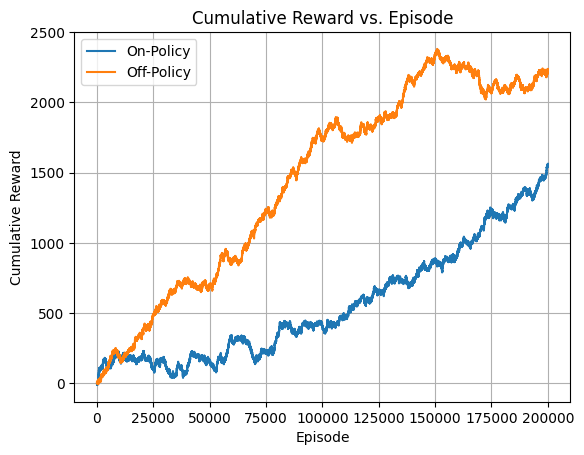

In [76]:
plot_cumulative_rewards(on_policy_episodes, off_policy_episodes)